<a href="https://colab.research.google.com/github/kayleepho/MATH-5750-Project-1/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Math 5750/6880: Mathematics of Data Science \\
Project 1

# 3. Python and Google Colab
Project Euler Problem  
https://projecteuler.net/

**Problem 952**

Given a prime $p$ and a positive integer $n < p$, let $R(p, n)$ be the **multiplicative order** of $p$ molulo $n!$

In other words, $R(p, n)$ is the minimal positive integer $r$ such that $$p^r \equiv 1 \pmod{n!}$$

For example, $R(7, 4) = 2$ and $R(10^9 + 7, 12) = 17280$.

Find $R(10^9 + 7, 10^7)$. Give your answer modulo $10^9 + 7$





In [36]:
import math
from array import array
from collections import defaultdict

In [42]:
# Step 1: Prime Sieve for smallest prime factors
def sieve_spf(limit):
    spf = array('I', [0]) * (limit + 1)
    primes = []
    for i in range(2, limit+1):
        if spf[i] == 0:
            spf[i] = i
            primes.append(i)
        for pr in primes:
            v = i * pr
            if v > limit:
                break
            spf[v] = pr
            if pr == spf[i]:
                break
    return primes, spf

In [38]:
# Step 2: Factorize x with smallest prime factor (SPF) if possible, else trial division
def factorize_with_spf(x, primes, spf):
    res = {}
    if x <= 1: #it has no prime factors
      return res
    limit = len(spf) - 1
    if x <= limit:
        while x > 1:
            p = spf[x]
            cnt = 0
            while x % p == 0:
                x //= p
                cnt += 1
            res[p] = res.get(p,0) + cnt
        return res
    # fallback trial division
    for pr in primes:
        if pr*pr > x:
          break
        if x % pr == 0:
            cnt = 0
            while x % pr == 0:
                x //= pr
                cnt += 1
            res[pr] = cnt
    if x > 1:
        res[x] = res.get(x,0) + 1
    return res

In [51]:
# Exponent of prime q dividing x
def v_q_of(x, q):
    cnt = 0
    while x % q == 0 and x > 0:
        x //= q
        cnt += 1
    return cnt

# Multiplicative order of p mod prime q
def order_mod_prime(p, q, primes, spf):
    phi = q - 1
    fac = factorize_with_spf(phi, primes, spf)
    d = phi
    for pr in sorted(fac.keys()):
        while d % pr == 0 and pow(p, d//pr, q) == 1:
            d //= pr
    return d

In [48]:
# Multiplicative order of p modulo q^e
def order_mod_prime_power(p, q, e, primes, spf):
    if q == 2:
        d = 1 if pow(p,1,4) == 1 else 2
        val = pow(p, d) - 1
        k0 = v_q_of(val, 2)
        if e <= k0:
            return d
        else:
            return d * (2 ** (e - k0))
    else:
        d = order_mod_prime(p, q, primes, spf)
        # compute q-adic valuation of p^d - 1
        k0 = 0
        mod = q
        while True:
            mod *= q
            if pow(p, d, mod) == 1:
                k0 += 1
                if k0 >= e: break
            else:
                break
        if e <= k0:
            return d
        else:
            return d * (q ** (e - k0))

In [49]:
def compute_R_mod_p(p, n, primes, spf, debug=False):
    max_exp = defaultdict(int)
    for q in primes:
        if q > n: break
        # exponent of q in n! (Legendre)
        e = 0
        t = q
        while t <= n:
            e += n // t
            t *= q
        if e == 0: continue
        ord_qe = order_mod_prime_power(p, q, e, primes, spf)
        f = factorize_with_spf(ord_qe, primes, spf)
        for pr, ex in f.items():
            if ex > max_exp[pr]:
                max_exp[pr] = ex
        if debug:
            print(f"q={q}, e={e}, ord(q^e)={ord_qe}, factors={f}")
    result = 1
    for pr, ex in sorted(max_exp.items()):
        result = (result * pow(pr, ex, p)) % p
    return result

In [67]:
# Small test
p = 10**9 + 7
n = 12
primes, spf = sieve_spf(n)
res12 = compute_R_mod_p(p, n, primes, spf, debug=True)
print("\nComputed R(10^9+7, 12) mod p =", res12)

# Brute force check on 12!
mod12fact = math.factorial(12)
r = 1
while pow(p, r, mod12fact) != 1:
    r += 1
print("Brute force R(10^9+7, 12) =", r)

# Problems
N = 10**5
primes, spf = sieve_spf(N)
answer = compute_R_mod_p(p, N, primes, spf, debug=False)
print("R(10^9+7, 10^5) mod (10^9+7) =", answer)

q=2, e=10, ord(q^e)=128, factors={2: 7}
q=3, e=5, ord(q^e)=162, factors={2: 1, 3: 4}
q=5, e=2, ord(q^e)=20, factors={2: 2, 5: 1}
q=7, e=1, ord(q^e)=14, factors={2: 1, 7: 1}
q=11, e=1, ord(q^e)=110, factors={2: 1, 5: 1, 11: 1}

Computed R(10^9+7, 12) mod p = 3991680
Brute force R(10^9+7, 12) = 17280
R(10^9+7, 10^5) mod (10^9+7) = 687288352


For N = 10^7, I have a trouble running it and do not know if there is an error in my code or becuase it is a large number so it takes long. but I can run with N = 10^5

# 4. Regression Analysis
California housing data  
https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Load the California housing data
cal = fetch_california_housing(as_frame=True)
X, y = cal.data, cal.target
feature_names = X.columns
print(feature_names)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


In [69]:
# Set up Linear Regression and explore other regression methods on this dataset
# Standardize Features (for Ridge/Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0).fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

# Lasso Regression
lasso_reg = Lasso(alpha=0.1).fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)


In [70]:
# Function to calculate metrics
def model_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# --- Compare Models ---
metrics = pd.DataFrame({
    "Linear": model_metrics(y_test, y_pred_lr),
    "Ridge": model_metrics(y_test, y_pred_ridge),
    "Lasso": model_metrics(y_test, y_pred_lasso)
}).T
metrics

,RMSE,MAE,R2
Linear,0.727313,0.535126,0.594323
Ridge,0.727321,0.535128,0.594314
Lasso,0.830684,0.627215,0.470813


In [72]:
# Linear Regression Model
print("Intercept:", lin_reg.intercept_)

# Get coefficients with feature names
coef_table2 = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_reg.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coef_table2

Intercept: -36.85856910680128


,Feature,Coefficient
3,AveBedrms,0.593215
7,Longitude,-0.434166
0,MedInc,0.433333
6,Latitude,-0.421449
2,AveRooms,-0.098643
1,HouseAge,0.009293
5,AveOccup,-0.004745
4,Population,-0.000008


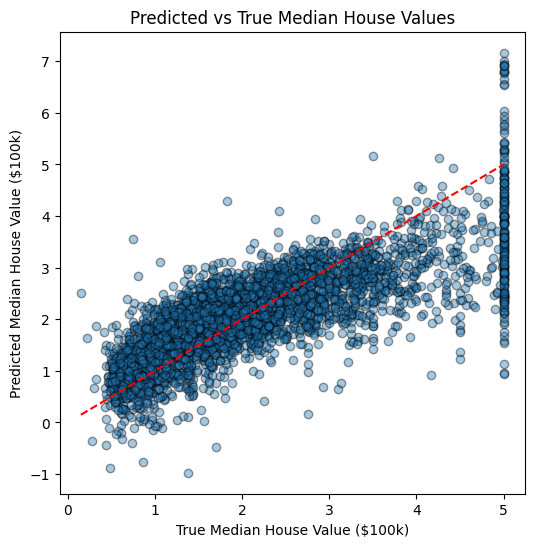

In [64]:
# Scatterplot of the predicted vs. true median house values (Linear Regression) ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.4, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True Median House Value ($100k)")
plt.ylabel("Predicted Median House Value ($100k)")
plt.title("Predicted vs True Median House Values")
plt.show()

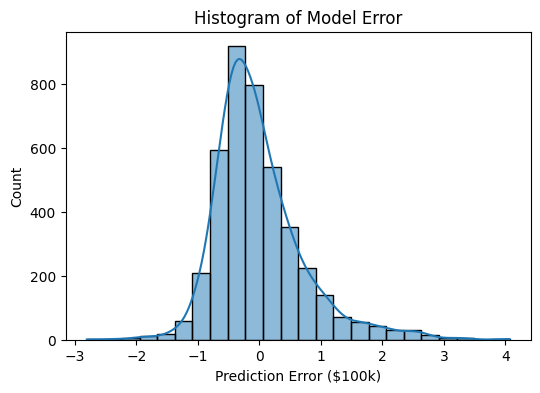

In [65]:
# Histogram of model error (Linear Regression)
errors = y_test - y_pred_lr
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=24, kde=True)
plt.xlabel("Prediction Error ($100k)")
plt.title("Histogram of Model Error")
plt.show()

# 5. Classification Analysis
Diagnostic Wisconsin Breast Cancer Database  
https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score,
    average_precision_score, RocCurveDisplay,
    PrecisionRecallDisplay
)

In [41]:
# Load Breast Cancer Wisconsin Dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target                  # 0 = malignant, 1 = benign
feature_names = X.columns
label_names = {0: "malignant", 1: "benign"}
print(feature_names)

# Train/Test Split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# Preprocess Data (fit on train ONLY; then transform both)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)   # fit on train
X_test_std  = scaler.transform(X_test)        # transform test with train stats

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


In [42]:
# STrain SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=0)
svm_model.fit(X_train_std, y_train)

# Metrics
y_pred = svm_model.predict(X_test_std)
y_prob = svm_model.predict_proba(X_test_std)[:, 1]

acc = svm_model.score(X_test_std, y_test)
roc = roc_auc_score(y_test, y_prob)
ap  = average_precision_score(y_test, y_prob)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "ROC AUC", "Average Precision"],
    "Test": [acc, roc, ap]
})

metrics_df

,Metric,Test
0,Accuracy,0.964912
1,ROC AUC,0.993386
2,Average Precision,0.996035


TN: 40, FP: 2, FN: 2, TP: 70


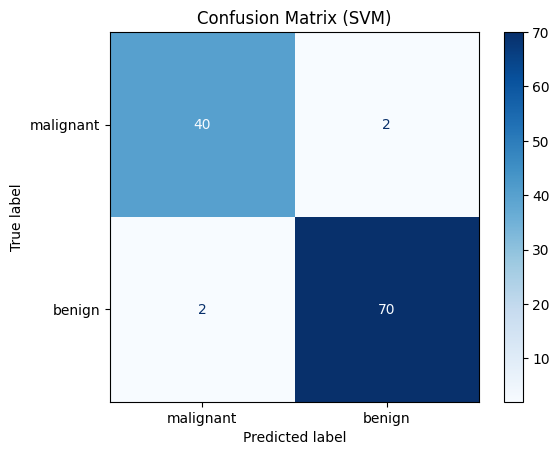

In [43]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Map to TN, FP, FN, TP
TN, FP, FN, TP = cm.ravel()
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

# Create a labeled DataFrame for display
cm_df = pd.DataFrame(
    [[TN, FP],
     [FN, TP]],
    index=['Actual Malignant', 'Actual Benign'],
    columns=['Predicted Malignant', 'Predicted Benign']
)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=data.target_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (SVM)")
plt.show()


In [44]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))



Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.95      0.95        42
      benign       0.97      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



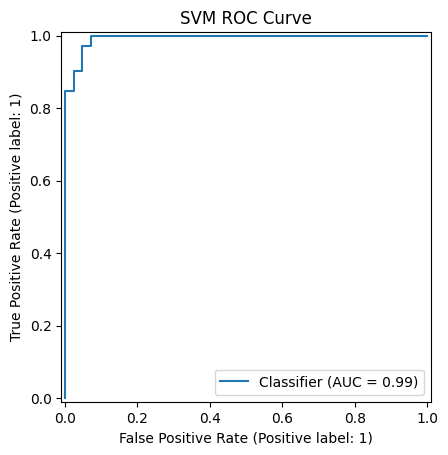

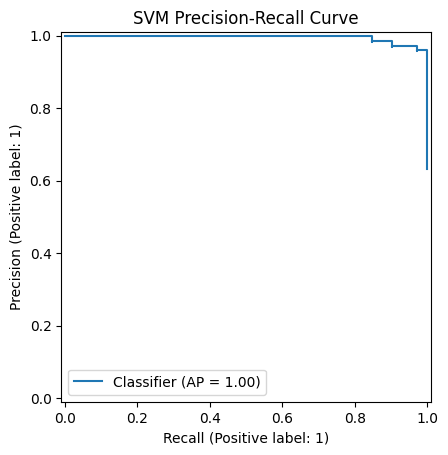

In [45]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("SVM ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("SVM Precision-Recall Curve")
plt.show()


Random Forest:
Accuracy: 0.9474
ROC AUC: 0.9729
Average Precision: 0.9698


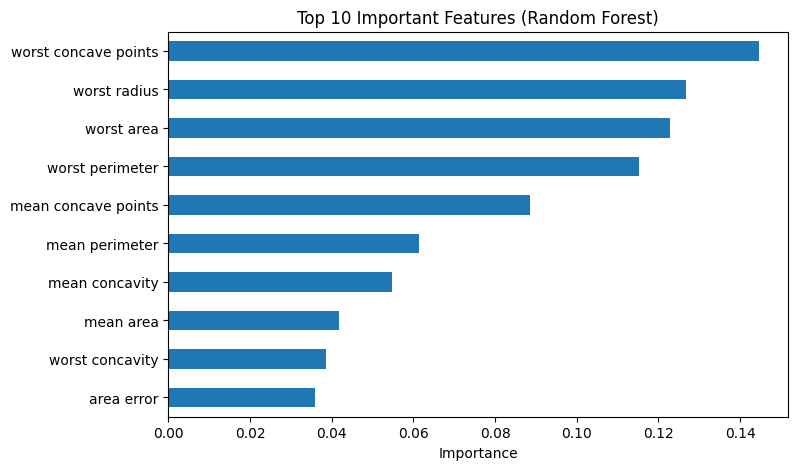

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)  # RF doesn’t need scaling

y_prob_rf = rf.predict_proba(X_test)[:, 1]
print("\nRandom Forest:")
print(f"Accuracy: {rf.score(X_test, y_test):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_prob_rf):.4f}")

# Feature importance from RF
importances = pd.Series(rf.feature_importances_, index=feature_names)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top10.plot(kind="barh")
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()